<a id=top-page></a>

# `pykitPIV` demo: Train a convolutional variational autoencoder

In this Jupyter notebook, we show how the available functionalities from the machine learning module ([`pykitPIV.ml`](https://pykitpiv.readthedocs.io/en/latest/user/ml.html)) can be used to train a convolutional variational autoencoder (CVAE). The trained CVAE model generates new velocity fields ($u$ and $v$ components) that belong to the distribution of some experimental data. New PIV snapshots can then be generated
with the newly generated velocity fields. Hence, this approach can be used to extend the training data for transfer learning and can help adapt a machine learning model to the changing experimental conditions.

Potentially, the simplified Langevin model (SLM) can be added atop the generated flow field samples to mitigate the smoothing effect that the variational autoencoder has. For this, the user can use the [`pykitPIV.FlowField.generate_langevin_velocity_field()`](https://pykitpiv.readthedocs.io/en/latest/user/flowfield.html#pykitPIV.flowfield.FlowField.generate_langevin_velocity_field) function.

Note that the CVAE implemented here is built with Gaussian normal priors which does limit the expressiveness of the latent space.

The illustration below shows the possible loop for training the CVAE:

<div style="text-align:center;">
    <img src="../docs/images/PIVCVAE.svg" style="height:500px">
</div>

This tutorial was built from: https://www.tensorflow.org/tutorials/generative/cvae.

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>
    <li><a href="#training-data">Create/load training data</a></li>
        <ul>
        <li><a href="#prepare-data">Prepare training data for TensorFlow</a></li>
        </ul>
    <li><a href="#parameteres-of-CVAE">Parameters of the convolutional variational autoencoder</a></li>
    <li><a href="#train-CVAE">Train the variational autoencoder</a></li>
    <li><a href="#sample">Visualize samples generated from the trained generative model</a></li>
</ol>
<p></p>
</div>
<br>

***

In [1]:
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
from pykitPIV import PIVDatasetPyTorch
from IPython import display
import glob
import imageio.v2 as imageio
import PIL
import time
from pykitPIV import FlowField, Image, PIVCVAE

2025-05-27 14:00:07.046324: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
save_images = False
filename = None

In [3]:
cmap = cmc.oslo_r

<a id=training-data></a>

***

## Create/load training data

[Go to the top](#top-page)

Below, we create dummy training data (velocity fields), which can be replaced by data coming from an experiment.

In [4]:
n_images = 2000
size = (28, 28)

In [5]:
flowfield = FlowField(n_images=n_images,
                      size=size,
                      size_buffer=0,
                      time_separation=1,
                      dtype=np.float32,
                      random_seed=100)

In [6]:
tic = time.perf_counter()

flowfield.generate_random_velocity_field(displacement=(1, 1),
                                         gaussian_filters=(5, 10),
                                         n_gaussian_filter_iter=3)

toc = time.perf_counter()

print(f'Total time: {(toc - tic)/60:0.1f} minutes.')

Total time: 0.0 minutes.


Inspect the training velocity field components:

In [7]:
image = Image()

In [8]:
image.add_flowfield(flowfield)

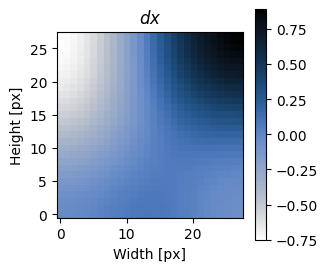

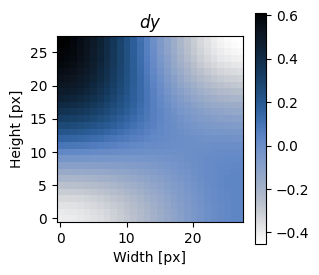

In [9]:
image.plot_field(0,
                 field='velocity',
                 with_buffer=True,
                 xlabel='Width [px]',
                 ylabel='Height [px]',
                 title=('$dx$', '$dy$'),
                 cmap=cmc.oslo_r,
                 cbar=True,
                 origin='lower',
                 figsize=(3,3),
                 filename=None);

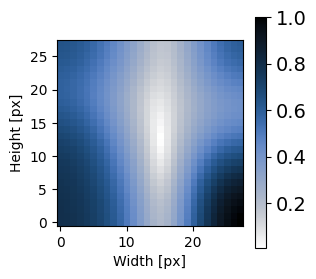

In [10]:
image.plot_field_magnitude(7,
                 field='velocity',
                 with_buffer=True,
                 xlabel='Width [px]',
                 ylabel='Height [px]',
                 cmap=cmc.oslo_r,
                 cbar=True,
                 figsize=(3,3),
                 filename=None);

<a id=prepare-data></a>

### Prepare training data for TensorFlow

[Go to the top](#top-page)

In [11]:
split_at = int(3*n_images/4)
split_at

1500

Normalize the velocity fields, so that each component in each image has a range between $\langle 0, 1 \rangle$:

In [12]:
vector_field = flowfield.velocity_field

min_vals = vector_field.min(axis=(2, 3), keepdims=True)
vector_field = vector_field - min_vals

max_vals = vector_field.max(axis=(2, 3), keepdims=True)
vector_field = vector_field / (max_vals)

Prepare tensor shapes for TensorFlow:

In [13]:
train_images = vector_field[0:split_at,:,:,:]
test_images = vector_field[split_at::,:,:,:]

train_images = np.transpose(train_images, (0, 2, 3, 1))
test_images = np.transpose(test_images, (0, 2, 3, 1))

In [14]:
train_images.shape

(1500, 28, 28, 2)

In [15]:
test_images.shape

(500, 28, 28, 2)

In [16]:
train_size = train_images.shape[0]
batch_size = 32
test_size = test_images.shape[0]

In [17]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size))

<a id=parameteres-of-CVAE></a>

***

## Parameters of the convolutional variational autoencoder

[Go to the top](#top-page)

In [18]:
n_channels = 2

In [19]:
input_shape = (size[0], size[1], n_channels)

Specify the learning rate and the optimizer:

In [20]:
learning_rate = 0.0001

In [21]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

Number of epochs:

In [22]:
n_epochs = 50

We specify the dimensionality of the latent space, $d$. Note that this dimensionality dictates how many independent marginal Gaussian distributions will be used to represent our input data. For example, for `latent_dim=2`, we will have two Gaussians, and therefore the vector of means will have two elements:

$$
\pmb{\mu} = [\mu_1, \mu_2]
$$

and the vector of log-variances will have two elements:

$$
\pmb{\ln(\sigma^2)} = [\ln(\sigma_1^2), \ln(\sigma_2^2)]
$$

In [23]:
latent_dim = 2

Number of new velocity fields to generate:

In [24]:
n_examples_to_generate = 16

We specify the random number, $\varepsilon$, for generation of new samples:

In [25]:
random_vector_for_generation = tf.random.normal(shape=[n_examples_to_generate, latent_dim])

We define the log- probability density function (log-PDF) for a (potentially multivariate) Gaussian distribution.


Recall that for a single Gaussian PDF, $\mathcal{N}(z \mid \mu, \sigma^2)$, we can compute its logarithm, which gives:

$$
\ln \big( \mathcal{N}(z \mid \mu, \sigma^2) \big) = -\frac{1}{2} \left( \frac{(z - \mu)^2}{\sigma^2} + \ln(2\pi) + \ln \sigma^2 \right)
$$

This is precisely the computation done by the function below, but we also sum across all $d$ Gaussian distributions that we are creating in our CVAE (we always have `latent_dim` many of them):

$$
\text{log-PDF} = \sum_{j=1}^{d} \ln \big( \mathcal{N}(z \mid \mu_j, \sigma_j^2) \big)
$$

In [26]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    
    log2pi = tf.math.log(2.0 * np.pi)
    
    return tf.reduce_sum(-0.5 * ((sample - mean) ** 2.0 * tf.exp(-logvar) + logvar + log2pi), axis=raxis)

Note that this summation does not mean that we are generating a Gaussian mixture! Rather, we are generating a product of the individual Gaussian marginals:

$$
p(\mathbf{z}) = \prod_{j=1}^{d} \mathcal{N}(z_j \mid \mu_j, \sigma_j^2)
$$

since the natural logarithm of this gives:

$$
\ln p(\mathbf{z}) = \sum_{j=1}^{d} \ln \mathcal{N}(z_j \mid \mu_j, \sigma_j^2)
$$

We define the complete loss function for the CVAE which, in essence, aims to maximize the evidence lower bound (ELBO).





In [27]:
def compute_loss(model, x):
    
    mean, logvar = model.encode(x)
    
    z = model.reparameterize(mean, logvar)
    
    x_logit = model.decode(z)
    
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    
    logpz = log_normal_pdf(z, 0.0, 0.0)
    
    logqz_x = log_normal_pdf(z, mean, logvar)
    
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

<a id=train-CVAE></a>

***

## Train the variational autoencoder

[Go to the top](#top-page)

In [28]:
@tf.function
def train_step(model, x, optimizer):
    
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Initialize the convolutional autoencoder as a `pykitPIV.ml.PIVCVAE` object:

In [29]:
model = PIVCVAE(input_shape=input_shape, 
                latent_dimension=latent_dim)

In [30]:
def generate_and_save_images(model, epoch, test_sample, component=0):
    
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(10, 10))
    
    for i in range(predictions.shape[0]):
          
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, component], cmap=cmap)
        plt.axis('off')
    
    if component==0:
        c = 'u'
    else:
        c = 'v'
    
    plt.savefig(c + '-component_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Select a test sample that will be used for generating output images:

In [31]:
assert batch_size >= n_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:n_examples_to_generate, :, :, :]

2025-05-27 14:00:27.300847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 50, Test set ELBO: -970.8363647460938, time elapse for current epoch: 1.0035109519958496


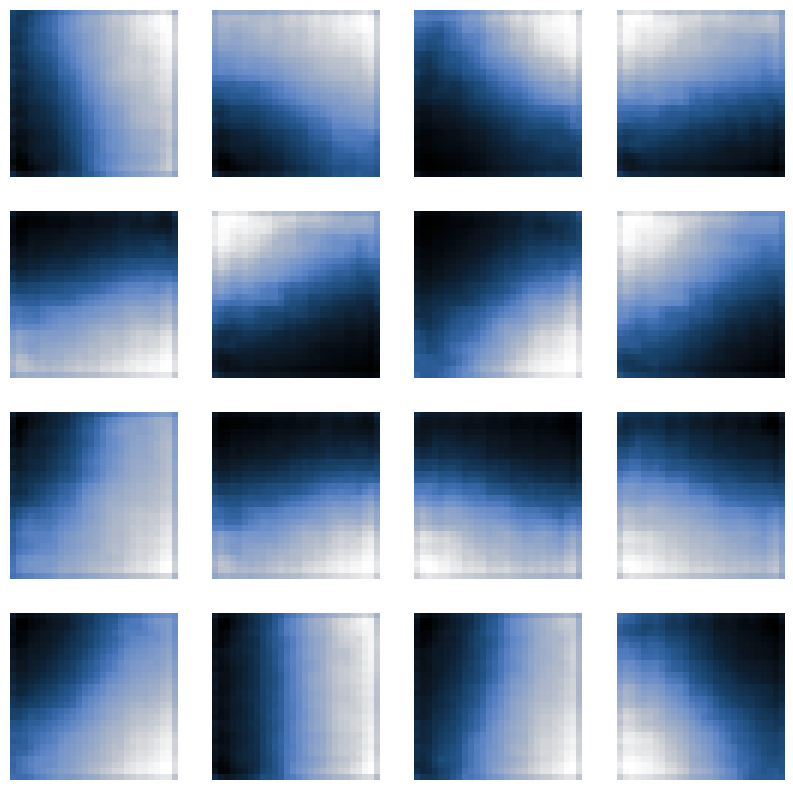

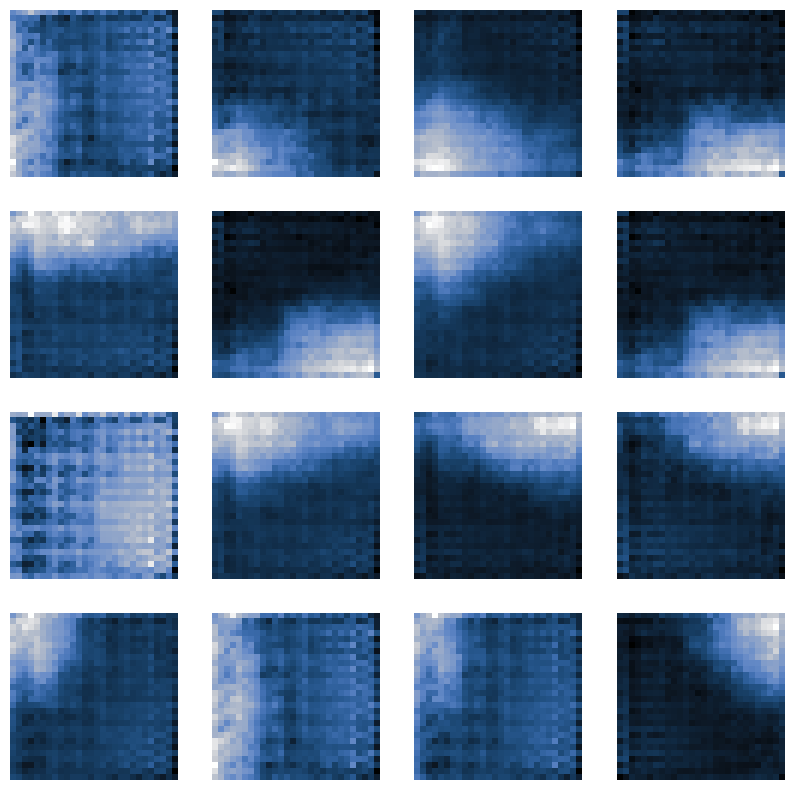

In [32]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, n_epochs + 1):
    
    start_time = time.time()
    
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
      
    elbo = -loss.result()
    
    display.clear_output(wait=False)
    
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'.format(epoch, elbo, end_time - start_time))
    
    generate_and_save_images(model, epoch, test_sample, component=0)
    generate_and_save_images(model, epoch, test_sample, component=1)

Animate the flow fields developing during the training process:

In [33]:
anim_file = 'cvae-training-u-component.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    
    filenames = glob.glob('u-component*.png')
    filenames = sorted(filenames)

    for filename in filenames:
        image_for_gif = imageio.imread(filename)
        writer.append_data(image_for_gif)
      
    image_for_gif = imageio.imread(filename)
    writer.append_data(image_for_gif)

In [34]:
anim_file = 'cvae-training-v-component.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    
    filenames = glob.glob('v-component*.png')
    filenames = sorted(filenames)

    for filename in filenames:
        image_for_gif = imageio.imread(filename)
        writer.append_data(image_for_gif)
      
    image_for_gif = imageio.imread(filename)
    writer.append_data(image_for_gif)

<a id=sample></a>

***

## Visualize samples generated from the trained generative model

[Go to the top](#top-page)

We first query the trained generative model:

In [35]:
mean, logvar = model.encode(test_sample)
z = model.reparameterize(mean, logvar)
predictions = model.sample(z)

We prepare the user-defined flowfield and import it to the `FlowField` class object:

In [36]:
user_flow_field = predictions.numpy()
user_flow_field = np.transpose(user_flow_field, (0, 3, 1, 2))
user_flow_field.shape

(16, 2, 28, 28)

In [37]:
flowfield = FlowField(n_images=n_examples_to_generate,
                      size=size,
                      size_buffer=0)

In [38]:
flowfield.upload_velocity_field(user_flow_field)

Finally, we can visualize the generated flow field magnitude samples:

In [39]:
image = Image()

In [40]:
image.add_flowfield(flowfield)

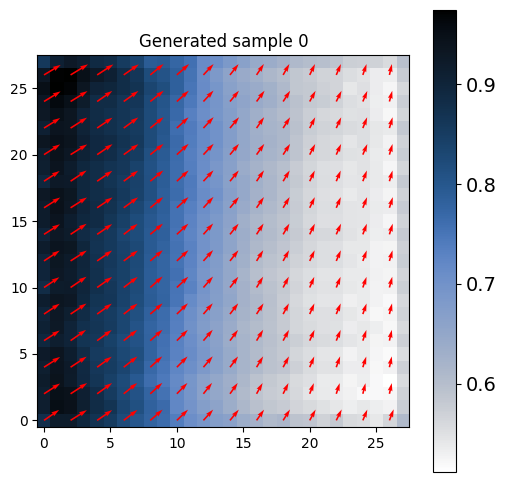

In [48]:
sample = 0

image.plot_field_magnitude(sample,
                           field='velocity',
                           with_buffer=False,
                           yticks=True,
                           title='Generated sample ' + str(sample),
                           cmap=cmap,
                           add_quiver=True,
                           quiver_step=2,
                           quiver_color='r',
                           figsize=(6, 6));

***

© K. Zdybał, C. Mucignat, S. Kunz, I. Lunati (2025)